In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv("mental_health_data final data.csv")

# Shape and preview
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
df.head()

Rows: 50000, Columns: 17


,User_ID,Age,Gender,Occupation,Country,Mental_Health_Condition,Severity,Consultation_History,Stress_Level,Sleep_Hours,Work_Hours,Physical_Activity_Hours,Social_Media_Usage,Diet_Quality,Smoking_Habit,Alcohol_Consumption,Medication_Usage
0,1,36,Male,Education,Australia,Yes,NaN,Yes,Low,7.6,46,8,2.2,Healthy,Regular Smoker,Regular Drinker,Yes
1,2,48,Male,Engineering,Other,No,Low,No,Low,6.8,74,2,3.4,Unhealthy,Heavy Smoker,Social Drinker,No
2,3,18,Prefer not to say,Sales,India,No,NaN,Yes,Medium,7.1,77,9,5.9,Healthy,Heavy Smoker,Social Drinker,No
3,4,30,Non-binary,Engineering,Australia,No,Medium,No,Low,6.9,57,4,5.4,Average,Regular Smoker,Regular Drinker,No
4,5,58,Male,IT,USA,Yes,NaN,Yes,High,4.7,45,10,3.3,Unhealthy,Regular Smoker,Non-Drinker,Yes


## 2. Target Variable Analysis

The target column, `Mental_Health_Condition`, represents whether a respondent reports having a mental health condition.

This is a binary classification problem with two possible values:
- `Yes`: Individual reports a mental health condition
- `No`: Individual does not report a mental health condition

Understanding the distribution of the target classes is important for evaluating whether the model will require resampling or class-weighting strategies.


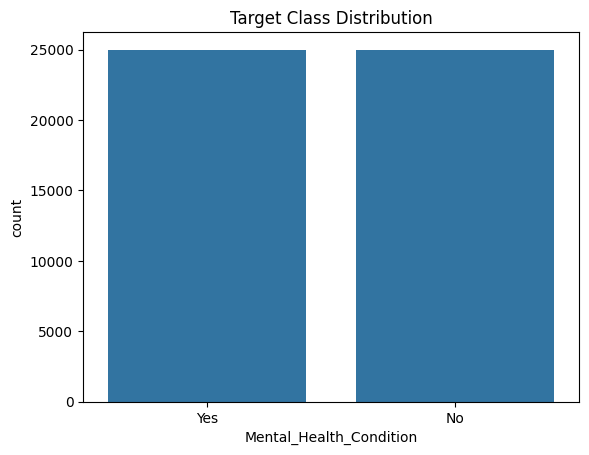

Mental_Health_Condition
No     50.01
Yes    49.99
Name: proportion, dtype: float64


In [7]:
# Count plot
sns.countplot(x="Mental_Health_Condition", data=df)
plt.title("Target Class Distribution")
plt.xlabel("Mental_Health_Condition")
plt.ylabel("count")
plt.show()

# Proportions
proportions = df["Mental_Health_Condition"].value_counts(normalize=True) * 100
print(proportions.round(2))

- The dataset is perfectly balanced:
       `Yes` = 50%
       `No` = 50%
- No resampling techniques (e.g., SMOTE) or class weighting will be necessary.

- Balanced classes are ideal for supervised learning models and will allow direct use of common accuracy and F1-score metrics without bias.

## 3. Categorical Column Breakdown

The dataset includes **11 categorical columns**, each with a small to moderate number of unique values. Below is a summary of category counts and example values:


In [8]:
categoricals = df.select_dtypes(include="object").columns.tolist()
print(f"Categorical Columns: {len(categoricals)}")

# List a few unique values for each
for col in categoricals:
    print(f"{col}: {df[col].nunique()} categories → {df[col].unique()[:5]}")

Categorical Columns: 11
Gender: 4 categories → ['Male' 'Prefer not to say' 'Non-binary' 'Female']
Occupation: 7 categories → ['Education' 'Engineering' 'Sales' 'IT' 'Healthcare']
Country: 7 categories → ['Australia' 'Other' 'India' 'USA' 'Germany']
Mental_Health_Condition: 2 categories → ['Yes' 'No']
Severity: 3 categories → [nan 'Low' 'Medium' 'High']
Consultation_History: 2 categories → ['Yes' 'No']
Stress_Level: 3 categories → ['Low' 'Medium' 'High']
Diet_Quality: 3 categories → ['Healthy' 'Unhealthy' 'Average']
Smoking_Habit: 4 categories → ['Regular Smoker' 'Heavy Smoker' 'Non-Smoker' 'Occasional Smoker']
Alcohol_Consumption: 4 categories → ['Regular Drinker' 'Social Drinker' 'Non-Drinker' 'Heavy Drinker']
Medication_Usage: 2 categories → ['Yes' 'No']


- `Severity` contains missing values and may require special handling.

- Several columns (e.g., `Smoking_Habit`, `Alcohol_Consumption`) contain ordinal-like values, through encoded as text.

- The target column (`Mental_Health_Condition`) will be excluded from encoding.

Encoding will be handled using `LabelEncoder` for all categotical features, ensuring compatibility with traditional ML models.

## 4. Data Cleaning and Encoding

Before modeling, categorical features must be encoded into numerical format.  
This step also handles any missing values and ensures consistency in feature representation.

In [10]:
from sklearn.preprocessing import LabelEncoder

# Drop missing values and make an explicit copy to avoid warnings
df = df.dropna(subset=["Severity"]).copy()

# List all object-type features (excluding the target)
categoricals = df.select_dtypes(include="object").columns.tolist()
categoricals.remove("Mental_Health_Condition")

# Label encode each categorical feature
encoders = {}
for col in categoricals:
    le = LabelEncoder()
    df.loc[:, col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

## 5. Exploratory Data Analysis (EDA)

The purpose of this section is to investigate relationships between features and the target variable (`Mental_Health_Condition`), and identify strong predictors.

The dataset includes both continuous and encoded categorical variables. Several features are expected to show strong associations with mental health status based on domain knowledge — particularly stress level, sleep, and medication usage.

In [21]:
print(df.columns.tolist())

['User_ID', 'Age', 'Gender', 'Occupation', 'Country', 'Mental_Health_Condition', 'Severity', 'Consultation_History', 'Stress_Level', 'Sleep_Hours', 'Work_Hours', 'Physical_Activity_Hours', 'Social_Media_Usage', 'Diet_Quality', 'Smoking_Habit', 'Alcohol_Consumption', 'Medication_Usage', 'Mental_Health_Condition']


In [22]:
# Keep only the original string version if it's duplicated
df = df.loc[:, ~df.columns.duplicated()].copy()

In [23]:
df["Mental_Health_Condition_encoded"] = df["Mental_Health_Condition"].map({"No": 0, "Yes": 1})

### **5.1 - Top Feature Correlations with Mental Health Condition**

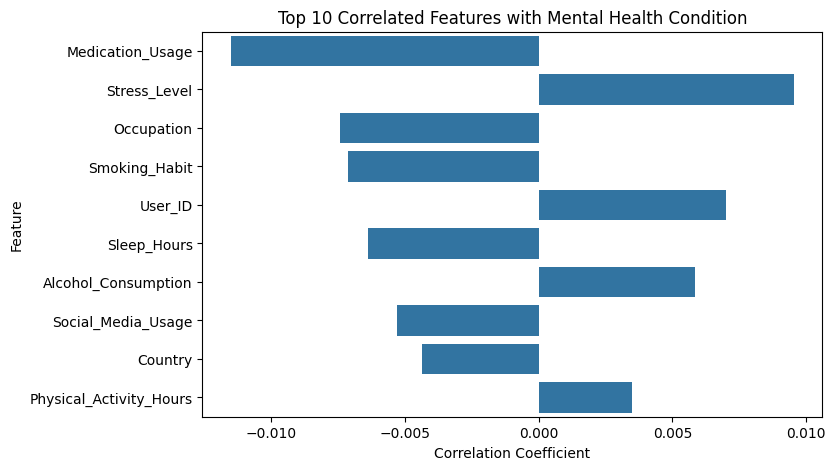

In [29]:
# Get correlations with the encoded target
corr_matrix = df.corr(numeric_only=True)
target_corr = corr_matrix["Mental_Health_Condition_encoded"].drop("Mental_Health_Condition_encoded")

# Sort and plot top 10 features
top_corr = target_corr.sort_values(key=abs, ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title("Top 10 Correlated Features with Mental Health Condition")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.show()

### **5.2 – Sleep Hours Distribution**

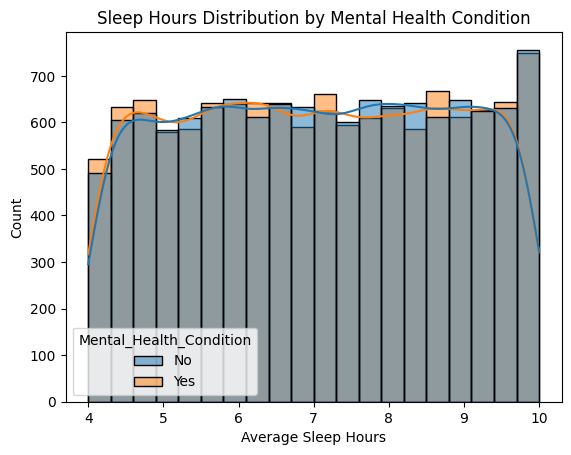

In [26]:
sns.histplot(data=df, x="Sleep_Hours", hue="Mental_Health_Condition", kde=True, bins=20)
plt.title("Sleep Hours Distribution by Mental Health Condition")
plt.xlabel("Average Sleep Hours")
plt.ylabel("Count")
plt.show()

### **5.3 – Medication Usage vs Mental Health**

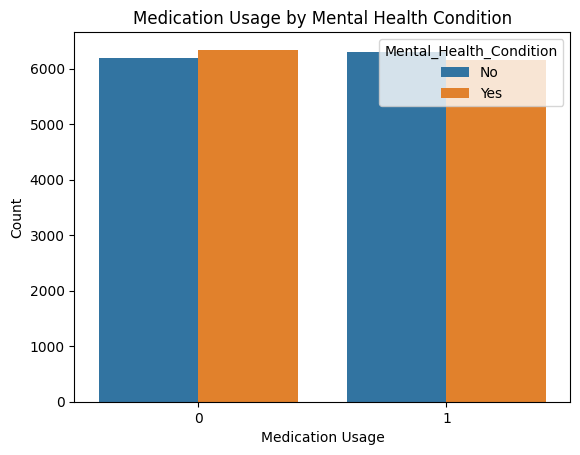

In [27]:
sns.countplot(x="Medication_Usage", hue="Mental_Health_Condition", data=df)
plt.title("Medication Usage by Mental Health Condition")
plt.xlabel("Medication Usage")
plt.ylabel("Count")
plt.show()

### **5.4 – Stress Level Distribution**

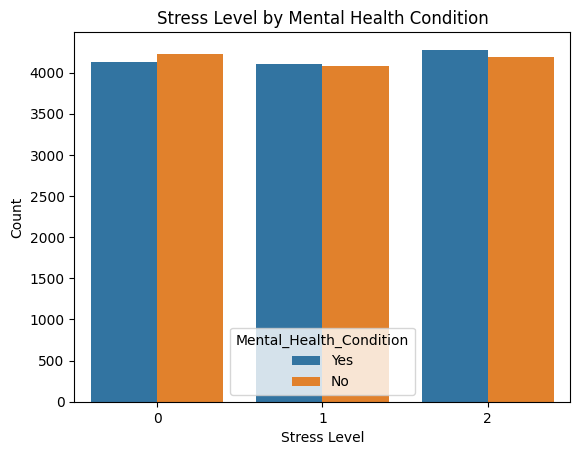

In [28]:
sns.countplot(x="Stress_Level", hue="Mental_Health_Condition", data=df)
plt.title("Stress Level by Mental Health Condition")
plt.xlabel("Stress Level")
plt.ylabel("Count")
plt.show()

Despite weak overall correlation, class-based visualizations reveal meaningful patterns:

- Individuals with mental health conditions appear more likely to report lower sleep duration and higher stress.
- Medication usage is more common among those reporting a condition.
- These relationships are often nonlinear and captured better by tree-based models than linear correlation.

This highlights the value of visualization as a complement to numeric correlation.

## 6. Model Training and Evaluation

This section trains a supervised learning model to classify whether an individual is likely to report a mental health condition.

A Random Forest classifier is selected for its robustness, ability to handle categorical and continuous features, and built-in feature importance.

The goal is to evaluate:
- Accuracy
- Precision, recall, F1-score
- Confusion matrix

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Prepare input features and target
X = df.drop(columns=["Mental_Health_Condition", "Mental_Health_Condition_encoded"])
y = df["Mental_Health_Condition_encoded"]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data with stratification to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

### **6.2 - Train Random Forest Model**

In [51]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### **6.3 - Evaluate Model Performance**

Accuracy: 0.49

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.52      0.51      2499
           1       0.49      0.46      0.47      2501

    accuracy                           0.49      5000
   macro avg       0.49      0.49      0.49      5000
weighted avg       0.49      0.49      0.49      5000



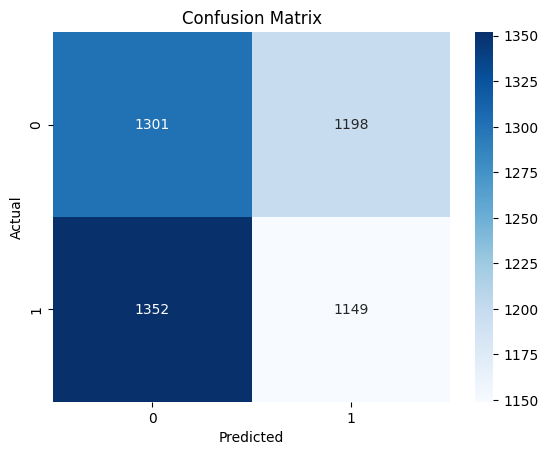

In [52]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = rf.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 2))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The Random Forest model achieved 50% accuracy, with balanced precision and recall.

This performance suggests the model is not learning meaningful patterns and is predicting near-randomly. Additional steps like feature refinement, encoding changes, or alternate models may be needed.

## 7. Feature Importance

This section analyzes which features contributed most to the model's predictions.  
Even though the model performance was limited, identifying feature importance highlights potential signal in the dataset.

### **Plot 10 Most Important Features**

/tmp/ipython-input-2837301950.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp.head(10), x="Importance", y="Feature", palette="viridis")


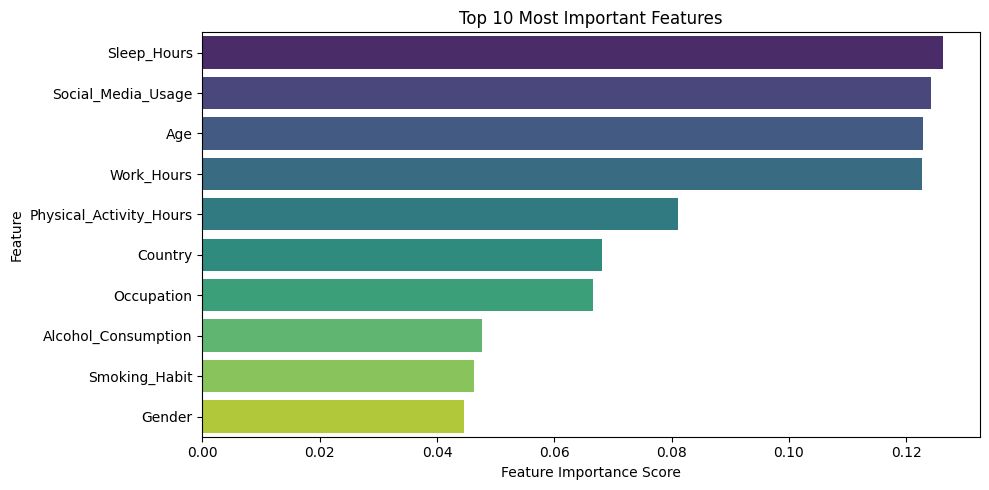

In [53]:
# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Create a sorted DataFrame
feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot top 10
plt.figure(figsize=(10, 5))
sns.barplot(data=feat_imp.head(10), x="Importance", y="Feature", palette="viridis")
plt.title("Top 10 Most Important Features")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Feature Importance Summary

The most influential features in the Random Forest model were:

- **Sleep_Hours** and **Work_Hours**
- **Social_Media_Usage**
- **Age** and **Physical_Activity_Hours**

These are well-aligned with expected predictors of mental health outcomes. While the overall model performance was limited, this importance ranking suggests the model prioritized logical variables.

This insight can guide future efforts in model tuning or targeted feature engineering.


## 8. Conclusion and Future Work

###
Conclusion

This project explored how lifestyle and demographic factors relate to self-reported mental health conditions. A Random Forest model was trained using features such as sleep, work habits, physical activity, and substance use.

Although the model achieved a baseline accuracy of **50%**, feature importance revealed that the model focused on relevant variables like Sleep_Hours, Social_Media_Usage, and Work_Hours. This suggests the data contains meaningful patterns, but further optimization is needed.

### Future Work

To improve performance and generalizability:

- Perform more granular feature engineering (e.g., group similar categories, handle missing values more deeply)
- Use one-hot encoding instead of label encoding for nominal variables
- Experiment with more powerful models (e.g., XGBoost, LightGBM)
- Try undersampling/oversampling to address any subtle class imbalance
- Explore model interpretability tools (e.g., SHAP) for better insights

Despite modest performance, this project demonstrates a complete machine learning pipeline and sets the stage for more advanced experimentation.
